In [1]:
import spacy
from gensim.parsing.preprocessing import strip_tags

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import joblib
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'}

pylab.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

import tqdm

In [22]:
class SpacyTokenizer():
    '''
    Custom tokenizer
    '''
    def __init__(self, model='en_core_web_sm'):
        self.model = model
        self.nlp = spacy.load(model)
        self.spacy_tokenizer = self.nlp.Defaults.create_tokenizer(self.nlp)
        self.stop_words = self.nlp.Defaults.stop_words
        
    def tokenizer(self, input_text: str):
        '''
        Preprocess and split text into tokens.
        
        Parameters:
        
        input_text: str
            Input text.
            
        Returns:
            np.ndarray: list of tokens
        '''
        text = strip_tags(input_text.lower())
        text = re.sub(r"[^A-Za-z]", " ", text)

        spacy_tokens = self.spacy_tokenizer(text)
        tokens = [token.lemma_.strip() for token in spacy_tokens 
                  if (len(token.lemma_.strip()) > 1) and not token.lemma_.strip() in self.stop_words]

        return tokens  
    
def get_top_n_words(corpus: np.ndarray, n: int=5, ngram_range: tuple=(1,3)):
    '''
    Get top common n-grams in corpus.
    
    Parameters:
    corpus: np.ndarray
        Array of texts.
    n: int (default: 5)
        Number of top n-grams to return.
    ngram_range: tuple (default: (1,3))
        Range of n-grams.
        
    Returns:
        np.ndarray: list of top common n-grams.
        
    '''
    
    tf_idf_vec = TfidfVectorizer(ngram_range=ngram_range, max_features=2000, tokenizer=SpacyTokenizer().tokenizer)
    tf_idf_vec.fit(corpus)

    bag_of_words = tf_idf_vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  tf_idf_vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

def tune_pipeline(pipeline: sklearn.pipeline, parameters: np.ndarray, X: pd.Series, y: pd.Series, n_splits: int=2):
    '''
    Find the best parameters for pipeline.
    
    Parameters:
    pipeline: sklearn.pipeline
        Pipeline for tunning.
    parameters: np.ndarray
        List of parameters are used for tunning.
    X: pd.Series
        Training vector.
    y: pd.Series
        Target vector relative to X.
    n_splits: int (default: 2)
        Number of re-shuffling and splitting iterations.
    
    Returns:
        sklearn.pipeline: tunned pipeline.
    '''
    grid_search = GridSearchCV(pipeline, parameters, 
        cv=StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42),
        n_jobs=-1, verbose=10)
    
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_

# Utils

# Read data

In [3]:
#If your dataset is too big you may use spark to read csv file. Look down
dataset_df = pd.read_csv('./dataset/kaggle_top30.csv')
print(f'Dataset size: {dataset_df.shape}')

Dataset size: (72292, 4)


In [ ]:
# pyspark = SparkSession.builder.appName('clf').config('spark.sql.execution.arrow.pyspark.enabled', "true")
# pyspark = pyspark.getOrCreate()
# dataset_df = pyspark.read.csv('./dataset/kaggle_top30.csv', header=True)
# dataset_df = dataset_df.toPandas()

In [4]:
dataset_df = dataset_df.drop_duplicates('Description')

In [5]:
dataset_df[:5]

,Unnamed: 0,Unnamed: 0.1,Query,Description
0,10,10,Administrative Assistant,This Administrative Assistant position is resp...
1,35,35,Administrative Assistant,ADMINISTRATIVE ASSISTANT Part Time The West Or...
2,140,140,Administrative Assistant,Administrative Assistant - In Bus 26yrs Fashi...
3,214,214,Sales Representative,Are you ready for something new? Are you tired...
4,350,350,Customer Service Representative,Superior Staff Resources is currently seeking ...


# EDA

In [6]:
dataset_df.count()

Unnamed: 0      31992
Unnamed: 0.1    31992
Query           31992
Description     31992
dtype: int64

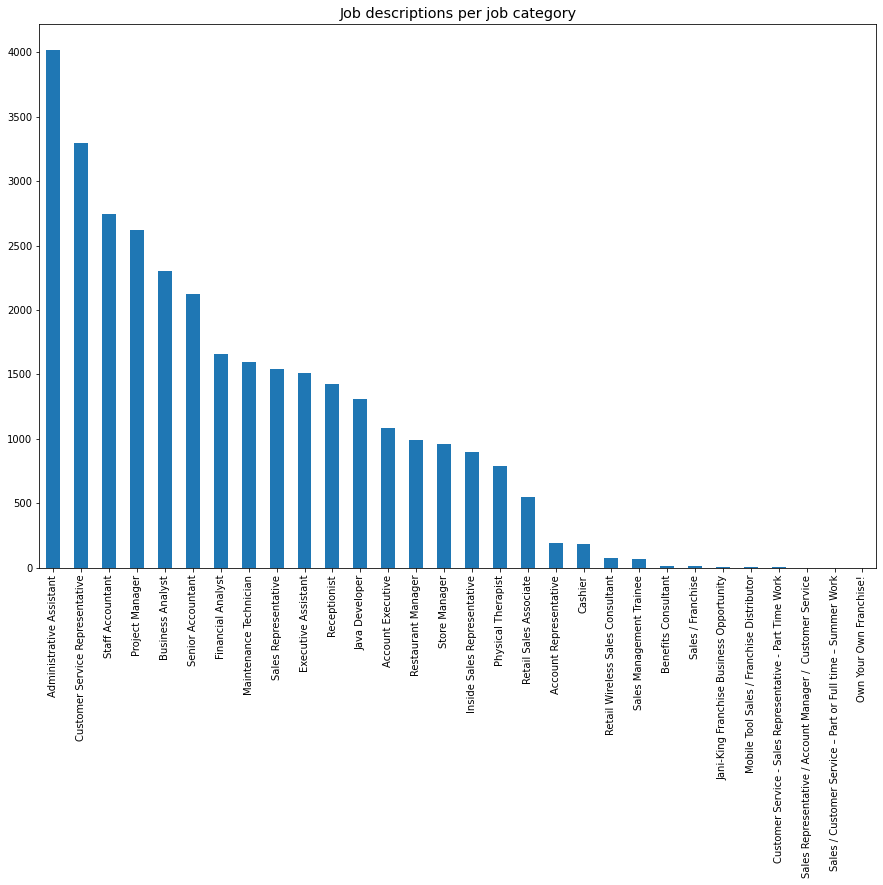

In [7]:
dataset_df['Query'].value_counts().plot(kind='bar')
plt.title('Job descriptions per job category')
plt.show()

In [8]:
for x in dataset_df['Query'].unique():
    if len(dataset_df[dataset_df['Query'] == x]) < 50:
        dataset_df = dataset_df[dataset_df['Query'] != x]

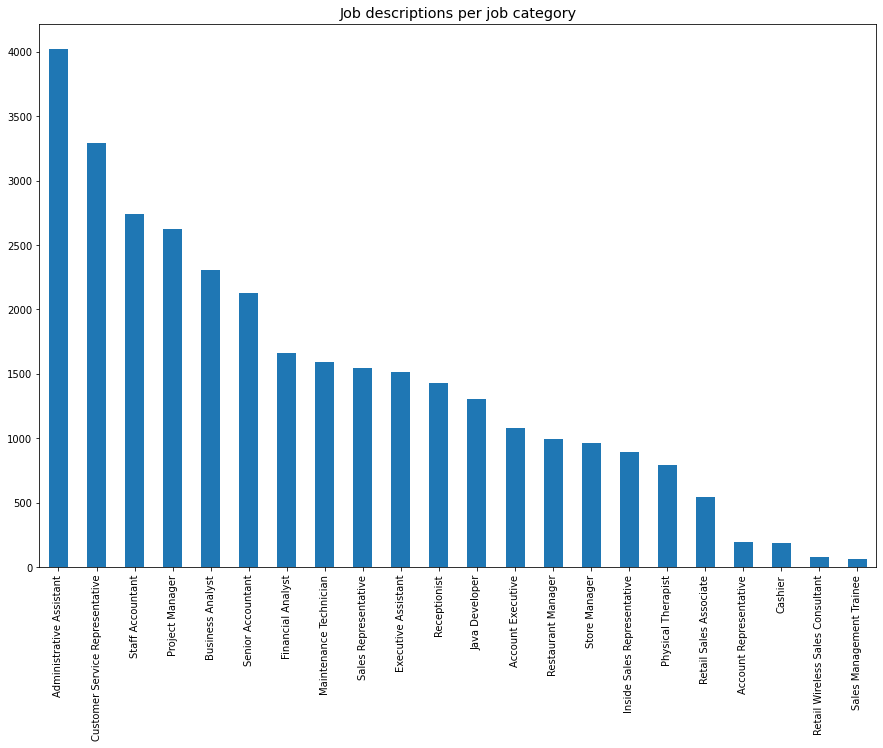

In [9]:
dataset_df['Query'].value_counts().plot(kind='bar')
plt.title('Job descriptions per job category')
plt.show()

In [10]:
dataset_df['Query'].value_counts()

Administrative Assistant            4017
Customer Service Representative     3294
Staff Accountant                    2743
Project Manager                     2621
Business Analyst                    2302
Senior Accountant                   2124
Financial Analyst                   1661
Maintenance Technician              1593
Sales Representative                1546
Executive Assistant                 1511
Receptionist                        1427
Java Developer                      1307
Account Executive                   1082
Restaurant Manager                   993
Store Manager                        963
Inside Sales Representative          897
Physical Therapist                   792
Retail Sales Associate               548
Account Representative               195
Cashier                              185
Retail Wireless Sales Consultant      76
Sales Management Trainee              67
Name: Query, dtype: int64

In [12]:
word_freq_dict = {}
for query in tqdm.tqdm(dataset_df['Query'].unique()):
    word_freq_dict[query] = get_top_n_words(dataset_df[dataset_df['Query']==query]['Description'], n=10, ngram_range=(1,4))

100%|██████████| 22/22 [40:42<00:00, 111.03s/it] 


In [13]:
for query in word_freq_dict:
    stat_string = "\n".join([f"{word_freq[0]:35} {word_freq[1]:.2f}" for word_freq in word_freq_dict[query]])
    print(f'''
===
{query}

{stat_string}
    ''')


===
Administrative Assistant

nbsp                                242.91
administrative                      231.05
assistant                           178.76
administrative assistant            164.01
office                              162.17
work                                136.95
support                             132.19
skill                               129.17
experience                          122.66
include                             121.85
    

===
Sales Representative

sale                                155.23
nbsp                                155.00
customer                            86.33
service                             70.91
representative                      63.40
business                            62.32
company                             61.12
product                             56.98
sale representative                 55.18
nbsp nbsp                           52.75
    

===
Customer Service Representative

customer                            381.85

# Preprocessing

Raw data

In [14]:
dataset_df['Description'][0]

'This Administrative Assistant position is responsible for performing a variety of clerical and administrative support functions in the areas of communications, data entry and retrieval, typing, filing, copying, and coordination of related administrative activities. \\r\\n\\r\\nJOB REQUIREMENTS:\\r\\nAttention to detail\\r\\nAbility to work in a fast paced environment\\r\\nInvoicing\\r\\nProficient in Word, Excel and Outlook\\r\\nOther Administrative responsibilities as needed.\\r\\n\\r\\nQUALIFICATIONS:\\r\\nHigh School Diploma\\r\\nAdministrative Assistant Experience\\r\\n1-2 Years work experience\\r\\nWorking knowledge of all basic office machines (fax, copier, 10key, etc.)\\r\\nStrong verbal and written communication skills\\r\\nStrong work ethic.'

Remove tags and stop words

In [15]:
SpacyTokenizer().tokenizer(dataset_df['Description'][0])

['administrative',
 'assistant',
 'position',
 'responsible',
 'perform',
 'variety',
 'clerical',
 'administrative',
 'support',
 'function',
 'area',
 'communication',
 'datum',
 'entry',
 'retrieval',
 'type',
 'file',
 'copy',
 'coordination',
 'relate',
 'administrative',
 'activity',
 'njob',
 'requirement',
 'nattention',
 'detail',
 'nability',
 'work',
 'fast',
 'pace',
 'environment',
 'ninvoicing',
 'nproficient',
 'word',
 'excel',
 'outlook',
 'nother',
 'administrative',
 'responsibility',
 'need',
 'nqualifications',
 'nhigh',
 'school',
 'diploma',
 'nadministrative',
 'assistant',
 'experience',
 'year',
 'work',
 'experience',
 'nworking',
 'knowledge',
 'basic',
 'office',
 'machine',
 'fax',
 'copier',
 'key',
 'etc',
 'nstrong',
 'verbal',
 'write',
 'communication',
 'skill',
 'nstrong',
 'work',
 'ethic']

# Classifier

In [16]:
def split_train_test(dataset_df, y, test_size=0.2):
    # remove types occur only ones
    temp_df = dataset_df[y.isin(y.value_counts()[y.value_counts()>1].index)]
    return train_test_split(temp_df, stratify=y, test_size=test_size, random_state=42)

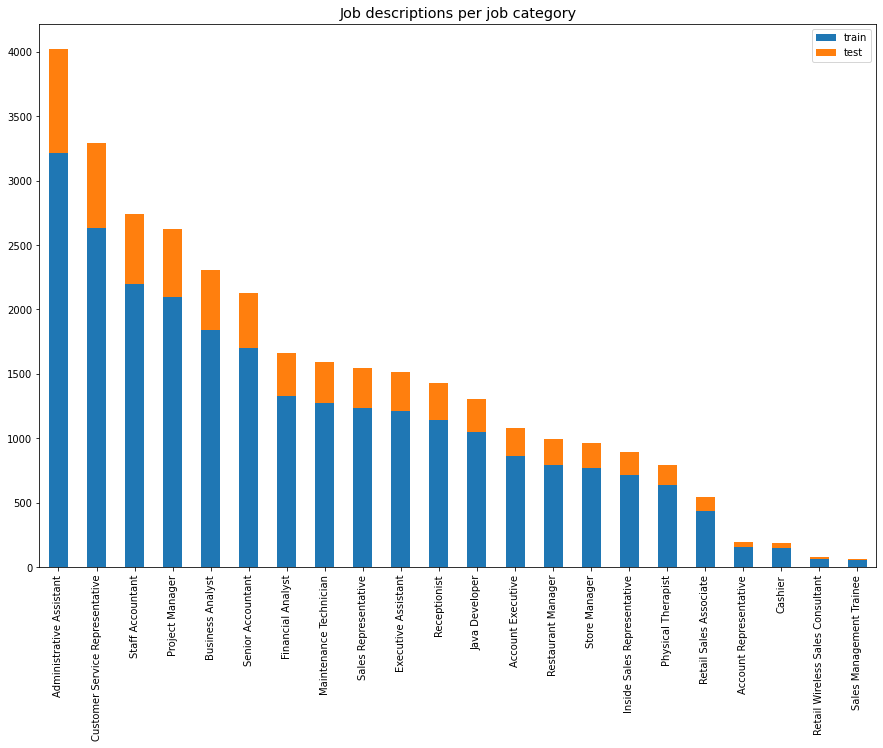

In [17]:
train, test = split_train_test(dataset_df, dataset_df['Query'], test_size=0.2)
split_df = pd.concat([train['Query'].value_counts(), test['Query'].value_counts()], axis=1)
split_df.columns = ['train', 'test']

split_df.plot(kind='bar', stacked=True)
plt.title('Job descriptions per job category')
plt.show()

In [18]:
print(f"train/test: {split_df['train'].sum()}/{split_df['test'].sum()}")
split_df

train/test: 25555/6389


,train,test
Administrative Assistant,3213,804
Customer Service Representative,2635,659
Staff Accountant,2194,549
Project Manager,2097,524
Business Analyst,1841,461
Senior Accountant,1699,425
Financial Analyst,1329,332
Maintenance Technician,1274,319
Sales Representative,1237,309
Executive Assistant,1209,302


## Naive Bayes classifier

In [19]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=SpacyTokenizer().tokenizer, max_features=2000)),
    ('clf', MultinomialNB(fit_prior=True, class_prior=None)),
])

parameters = {
    'tfidf__ngram_range': [(1, 2)],
    'clf__alpha': (1e-2, 1e-3)
}

nb_pipeline = tune_pipeline(pipeline, parameters, train['Description'], train['Query'], n_splits=5)
print(nb_pipeline.steps)
joblib.dump(nb_pipeline, './models/nb_pipeline.joblib')

pred = nb_pipeline.predict(test['Description'])
print(classification_report(test['Query'], pred))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:  5.3min remaining:  5.3min
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 10.0min finished


[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<bound method SpacyTokenizer.tokenizer of <__main__.SpacyTokenizer object at 0x7fc36792db90>>)), ('clf', MultinomialNB(alpha=0.001))]
                                  precision    recall  f1-score   support

               Account Executive       0.78      0.79      0.79       216
          Account Representative       0.83      0.26      0.39        39
        Administrative Assistant       0.79      0.87      0.83       804
                Business Analyst       0.91      0.74      0.82       461
                         Cashier       0.89      0.65      0.75        37
 Customer Service Representative       0.82      0.77      0.80       659
             Executive Assistant       0.84      0.69      0.76       302
               Financial Analyst       0.77      0.88      0.82       332
     Inside Sales Representative       0.76      0.47      0.58       179
                  Java Developer 

## LogisticRegression

In [20]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=SpacyTokenizer().tokenizer, max_features=2000)),
    ('clf', LogisticRegression(solver='sag')),
])
parameters = {
    'tfidf__ngram_range': [(1, 2)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
}

logistic_regression_pipeline = tune_pipeline(pipeline, parameters, train['Description'], train['Query'], n_splits=5)
print(logistic_regression_pipeline.steps)
joblib.dump(logistic_regression_pipeline, './models/logistic_regression_pipeline.joblib')

pred = logistic_regression_pipeline.predict(test['Description'])
print(classification_report(test['Query'], pred))

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 10.8min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 26.1min
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed: 31.6min finished


[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<bound method SpacyTokenizer.tokenizer of <__main__.SpacyTokenizer object at 0x7fc2d4734ed0>>)), ('clf', LogisticRegression(C=1, solver='sag'))]
                                  precision    recall  f1-score   support

               Account Executive       0.86      0.89      0.88       216
          Account Representative       0.91      0.26      0.40        39
        Administrative Assistant       0.87      0.92      0.90       804
                Business Analyst       0.94      0.93      0.93       461
                         Cashier       1.00      0.68      0.81        37
 Customer Service Representative       0.89      0.96      0.92       659
             Executive Assistant       0.89      0.82      0.85       302
               Financial Analyst       0.94      0.93      0.94       332
     Inside Sales Representative       0.83      0.73      0.78       179
                  Java

## DecisionTreeClassifier

In [23]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=SpacyTokenizer().tokenizer, max_features=2000)),
    ('clf', DecisionTreeClassifier()),
])
parameters = {
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    "clf__class_weight": ['balanced', None],
}

decision_tree_pipeline = tune_pipeline(pipeline, parameters, train['Description'], train['Query'], n_splits=5)
print(decision_tree_pipeline.steps)
joblib.dump(decision_tree_pipeline, './models/decision_tree_pipeline.joblib')

pred = decision_tree_pipeline.predict(test['Description'])
print(classification_report(test['Query'], pred))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed: 12.0min remaining: 36.1min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed: 12.4min remaining: 20.6min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 12.4min remaining: 12.4min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed: 12.4min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 12.7min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 12.8min finished


[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<bound method SpacyTokenizer.tokenizer of <__main__.SpacyTokenizer object at 0x7fc2f4f28610>>)), ('clf', DecisionTreeClassifier())]
                                  precision    recall  f1-score   support

               Account Executive       0.80      0.81      0.81       216
          Account Representative       0.72      0.54      0.62        39
        Administrative Assistant       0.84      0.83      0.83       804
                Business Analyst       0.87      0.84      0.86       461
                         Cashier       0.57      0.65      0.61        37
 Customer Service Representative       0.88      0.91      0.89       659
             Executive Assistant       0.78      0.77      0.77       302
               Financial Analyst       0.89      0.85      0.87       332
     Inside Sales Representative       0.70      0.73      0.72       179
                  Java Developer   

## LinearSVC classifier

In [24]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=SpacyTokenizer().tokenizer, max_features=2000)),
    ('clf', LinearSVC(multi_class='ovr'))
])

parameters = {
    'tfidf__ngram_range': [(1, 2)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
}

linear_svc_pipeline = tune_pipeline(pipeline, parameters, train['Description'], train['Query'], n_splits=5)
print(linear_svc_pipeline.steps)
joblib.dump(linear_svc_pipeline, './models/linear_svc_pipeline.joblib')

pred = linear_svc_pipeline.predict(test['Description'])
print(classification_report(test['Query'], pred))

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed: 11.2min remaining: 33.7min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed: 11.6min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 11.8min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 17.7min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 18.2min finished


[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                tokenizer=<bound method SpacyTokenizer.tokenizer of <__main__.SpacyTokenizer object at 0x7fc2d50bfbd0>>)), ('clf', LinearSVC(C=1, class_weight='balanced'))]
                                  precision    recall  f1-score   support

               Account Executive       0.88      0.93      0.90       216
          Account Representative       0.62      0.64      0.63        39
        Administrative Assistant       0.92      0.87      0.90       804
                Business Analyst       0.94      0.93      0.94       461
                         Cashier       0.72      0.78      0.75        37
 Customer Service Representative       0.93      0.93      0.93       659
             Executive Assistant       0.83      0.87      0.85       302
               Financial Analyst       0.92      0.95      0.93       332
     Inside Sales Representative       0.77      0.83      0.80       179
                  Ja

# Test

In [25]:
classifier_pipeline = joblib.load('./models/linear_svc_pipeline.joblib')

In [26]:
test_record = test.sample().iloc[0]
print(f"Category: {test_record['Query']}")
print(f"Description: {test_record['Description']}")

Category: Project Manager
Description: <strong>Immediate opening for a Project Engineer!!</strong>\r\nAdecco Engineering and Technical, a division of the world leader in the recruitment of engineering and information technology professionals, has an immediate opening for an Project Manager on a direct hire opportunity with a leading company in Irvine, Ca. \r\n\r\n<strong> </strong>\r\n<strong>Qualifications:</strong>\r\n\r\n<li>B.S. Engineering required.\r\n</li>\r\n<li>Minimum 0-3 years engineering experience, preferably in a Medical Device or Bio-Pharm manufacturing environment\r\n</li>\r\n<li>Successful track record in project management and use of project management tools (i.e. MS Project) and team management techniques.\r\n</li>\r\n<li>Good understanding of quality systems and FDA regulations related to manufacturing.\r\n</li>\r\n<li>Experience with small batch and lot segregation processing preferred.\r\n</li>\r\n<li>Experience with human tissue based manufacturing preferred.\r\n

In [27]:
classifier_pipeline.predict([test_record['Description']])

array(['Project Manager'], dtype=object)